### Apresentação ✒️

Notebook destinado ao estudo de clusterização a partir do dataset de vinhos. 


#### Library 📚

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import DataFrame

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from yellowbrick.cluster import SilhouetteVisualizer

from factor_analyzer import calculate_bartlett_sphericity

#### Carregando o dataset 💾

In [3]:
file_path = "wine-clustering.csv"

df_raw = pd.read_csv(file_path)

In [4]:
df_raw.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
df_raw.shape

(178, 13)

In [6]:
df_raw.isnull().sum()

Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64

In [9]:
df_raw.duplicated().sum()

np.int64(0)

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


In [11]:
df_raw.describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Analisando as métricas estatísticas pode-se supor que os dados não apresentam outliers entre si. Para verificar tal aspecto de uma forma mais visual, pode-se adotar o gráfico de boxplot. Caso existam datapoints que superam tanto o limite inferior quanto superior, compreende-se que exista a presença de outliers. 

O tratamento acerca dos outliers depende de cada cenário particular, considerando a importância dos outliers presentes, bem como a quantidade de dados existentes no dataset. 

#### Análise exploratória dos dados

In [14]:
# Dicionary for use to fill the argumets in functios builded. 

parameters = {
    "dataset": df_raw,
    "style": "whitegrid", 
    "color": "coolwarm", 
    "height": 12, 
    "width": 6,
    "bins": 35
}

Verificando os outliers presentes no dataset a partir do gráfico de boxplot. 

In [19]:
def boxplot(
        dataset: DataFrame, 
        style: str, 
        height: int, 
        width: int
    ):
    """
    Generates boxplots for each feature in the dataset. Automatically creates multiple
    figures if the number of features exceeds six.

    Parameters:
    ----------
    dataset : DataFrame
        The dataset to be visualized.
    style : str
        Seaborn theme for plot styling (e.g., 'darkgrid', 'whitegrid').
    height : int
        The height of the figure in inches.
    width : int
        The width of the figure in inches.
    """
    sns.set_theme(style=style)
    
    features = dataset.columns
    num_features = len(features)

    # Maximum number of subplots per figure
    features_per_figure = 6  

    # Ceil division
    num_figures = (num_features + features_per_figure - 1) // features_per_figure  
    
    for fig_idx in range(num_figures):
        # Determine the features for the current figure
        start = fig_idx * features_per_figure
        end = min(start + features_per_figure, num_features)
        current_features = features[start:end]
        
        # Create the figure
        plt.figure(figsize=(width, height))
        
        for i, feature in enumerate(current_features, 1):
            plt.subplot(2, 3, i)
            sns.boxplot(data=dataset[feature])
            plt.title(f"Boxplot de {feature}", rotation = 90)
        
        plt.tight_layout()
        plt.show()


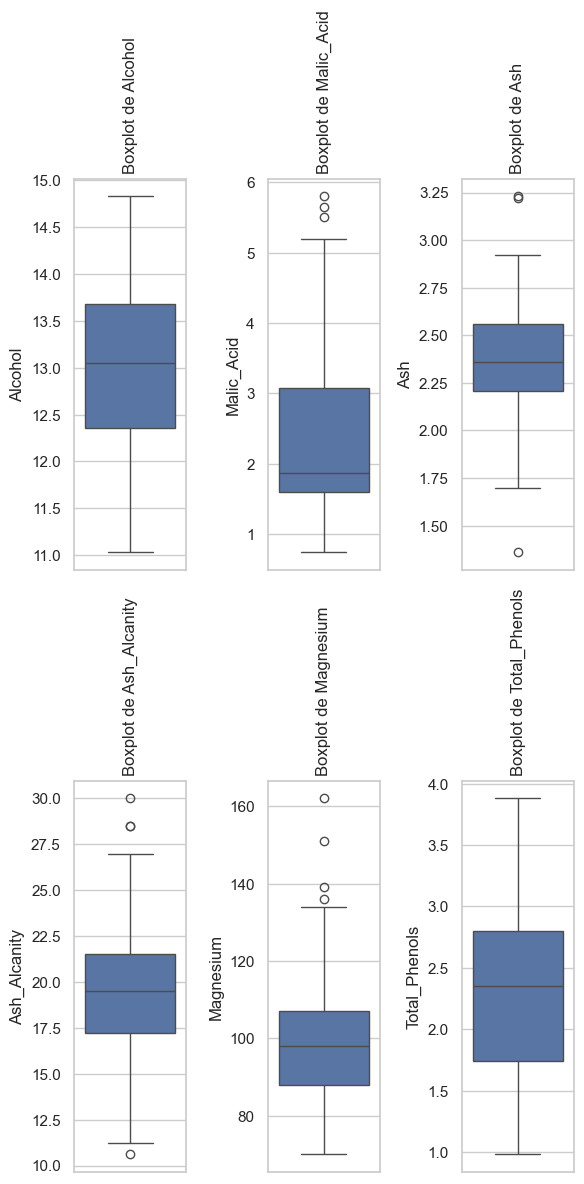

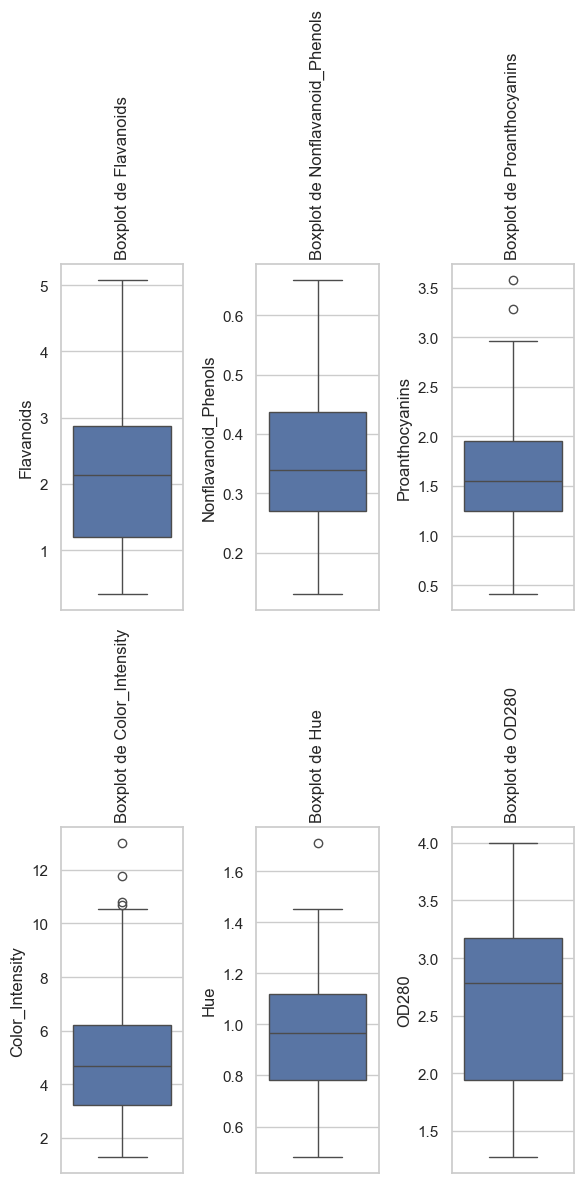

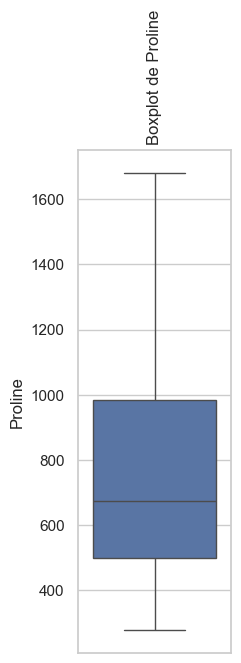

In [20]:
boxplot(
    dataset = df_raw, 
    style   = parameters["style"], 
    height  = parameters["height"], 
    width   = parameters["width"]
)


Verificando a distribuição dos dados.

In [23]:
def data_distribuition(
        dataset: DataFrame, 
        style : str, 
        height: int, 
        width: int, 
        bins: int
        ):
    """ 
    Visualizes the distribution of each feature in the dataset using histograms.

    Parameters:
    ----------
    dataset : DataFrame
        The dataset to be visualized, where each column represents a feature.
    
    style : str
        Seaborn theme for plot styling (e.g., 'darkgrid', 'whitegrid').
    
    height : int
        The height of the figure in inches.
    
    width : int
        The width of the figure in inches.
    
    bins : int
        Number of bins for the histograms.
    """
    feature = dataset.columns
    sns.set_theme(style=style)

    # Determinar o número de linhas no grid :
    
    # Fixo para 3 colunas
    n_cols = 3 

    # Calcular o número de linhas necessárias
    n_rows = (len(feature) + n_cols - 1) // n_cols  

    plt.figure(figsize=(height, width))

    for i, feature in enumerate(feature, 1):

        data = dataset[feature]

        plt.subplot(n_rows, n_cols, i)
        sns.histplot(data, kde=True, bins=bins)
        plt.title(f"Histograma de {feature}")


    plt.tight_layout()
    plt.show()

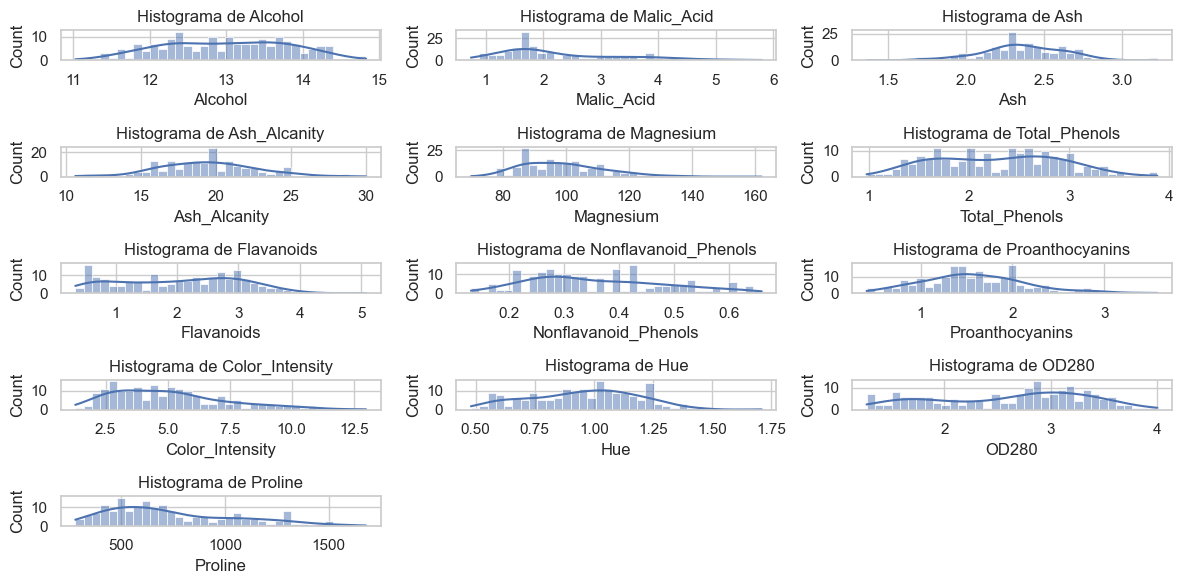

In [24]:
data_distribuition(
    dataset = df_raw, 
    style   = parameters["style"], 
    height  = parameters["height"], 
    width   = parameters["width"], 
    bins    = parameters["bins"]
)

Nota-se que a distribuição dos dados tendem a seguir uma curva normal, quando não apresentam uma cauda à direita, revelando a assimetria existente que no gráfico de boxplot também é captada em termos dos outliers existentes. A estratégia utilizada para ajustar a distribuição e diminuir a quantidade de outliers será a normalização, seguindo a direção necessária para o uso de modelos de clusterização que necessitam - para seu melhor comportamento - que os dados estejam escalonados ou sujeitos a um intervalo especifico. 

Verificando se os dados apresentam correlação linear. 

In [32]:
def pearson_matrix(
        dataset: DataFrame, 
        color: str, 
        height: int, 
        width: int
    ):
    """ 
    Generates a heatmap to visualize the Pearson correlation matrix of a dataset.

    Parameters:
    ----------
    dataset : DataFrame
        The dataset whose features' correlations will be computed and visualized.
    
    color : str
        The colormap for the heatmap (e.g., 'coolwarm', 'viridis').
    
    height : int
        The height of the heatmap figure in inches.
    
    width : int
        The width of the heatmap figure in inches.
    """
    corr_matrix = dataset.corr()

    plt.figure(figsize=(height, width))
    sns.heatmap(corr_matrix, annot=True, cmap=color, fmt=".2f")

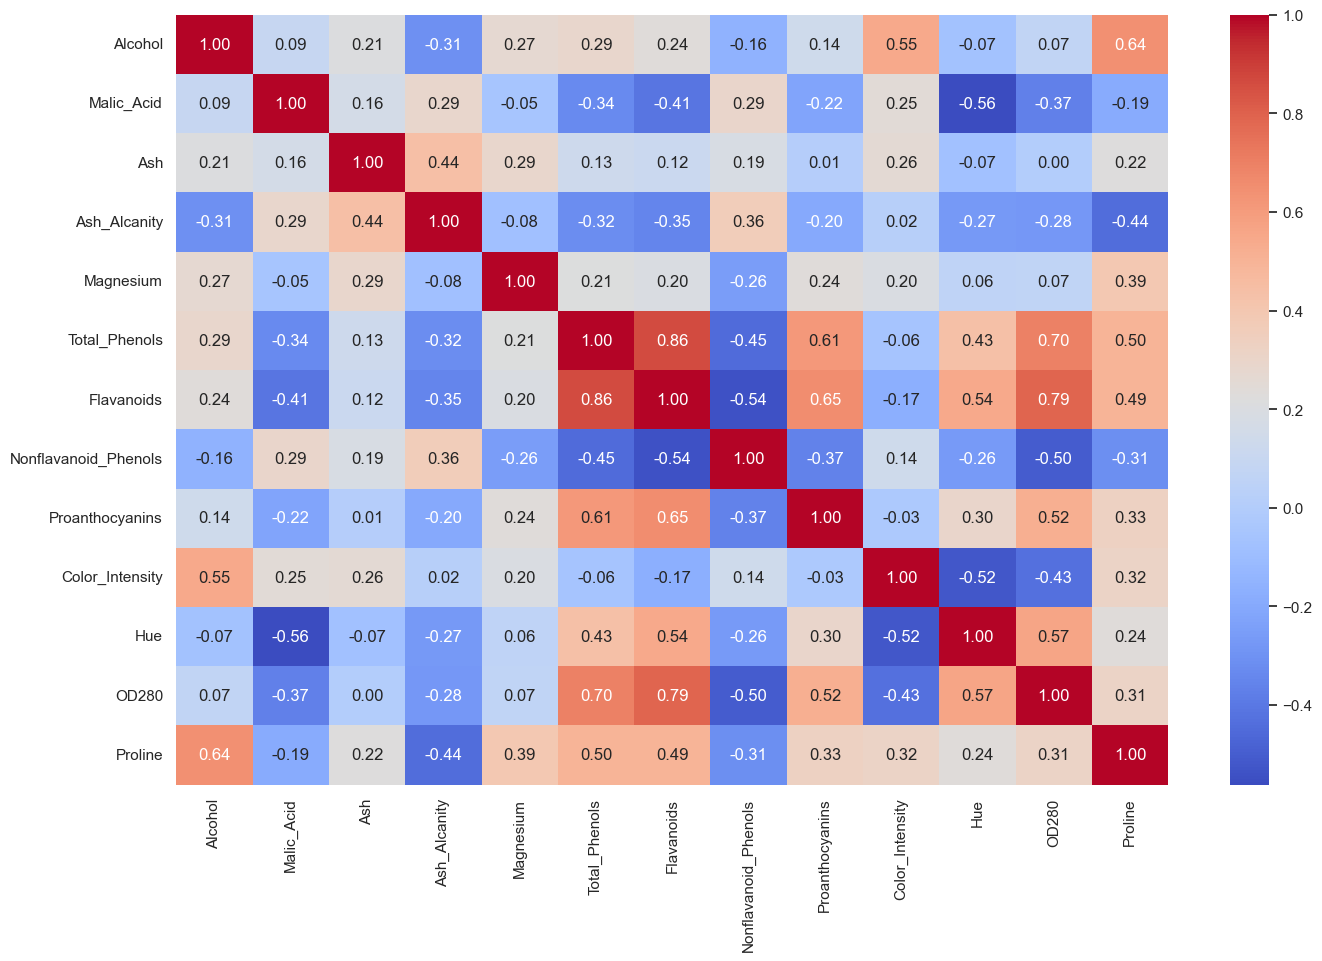

In [33]:
pearson_matrix(
    dataset = df_raw, 
    color   = parameters["color"], 
    height  = 16, 
    width   = 10
)

#### Verificando se o dataset pode ser passado para um PCA 

O PCA é uma técnica de redução de dimensionalidade, que forma novas features com base nas já pré-existentes, integrando aquelas que apresentam correlação entre si. Tal método estatístico busca reduzir a quantidade de features existentes em um dataset, mas sem perder significativamente o teor explicativo delas, mantendo as features que consigam compreender a maior variância dos dados. 

Antes de ser aplicado o PCA no dataset, pode ser interessante verificar se ele é proprício para a aplicação da técnica. Uma das formas de verificar isso se dá por meio do cálculo da esfericidade de Barlett, que compreende em termos de significância estatística se o dataset presente se difere de uma matriz identididade. Caso não seja diferente, compreende-se que os dados do dataset não apresentam relações lineares entre si, invalidando o uso do PCA. 

Em termos de interpretabilidade, tem-se que caso o valor-p, a um intervalo de confiança de 95%, seja inferior que 5%, os dados apresentam relações lineares entre si. Caso contrário, não. 

In [38]:
_, valor_p = calculate_bartlett_sphericity(df_raw)

if valor_p < 0.05:
    print(f"O dataset pode ser submetido ao PCA.\nValor-p: {valor_p}")
else:
    print("O dataset não pode ser submetido ao PCA, pois o seu valor-p é superior que 5%. ")

O dataset pode ser submetido ao PCA.
Valor-p: 2.4686170324251343e-224


#### Scaler



In [26]:
# Scaling the values with standard scaler. 

scaler = StandardScaler()

normalized_values = scaler.fit_transform(df_raw.values)

normalized_values[:2]

array([[ 1.51861254, -0.5622498 ,  0.23205254, -1.16959318,  1.91390522,
         0.80899739,  1.03481896, -0.65956311,  1.22488398,  0.25171685,
         0.36217728,  1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, -2.49084714,  0.01814502,
         0.56864766,  0.73362894, -0.82071924, -0.54472099, -0.29332133,
         0.40605066,  1.1134493 ,  0.96524152]])

In [27]:
# Rebuilding the dataframe with normalized values. 

df = pd.DataFrame(
    normalized_values, 
    columns = df_raw.columns, 
    index   = df_raw.index)

df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


#### PCA

In [40]:
pca = PCA(n_components=0.8, random_state=20)

df_pca = pd.DataFrame(pca.fit_transform(df))

In [41]:
df_pca.head()

,0,1,2,3,4
0,3.316751,1.443463,-0.165739,-0.215631,0.693043
1,2.209465,-0.333393,-2.026457,-0.291358,-0.257655
2,2.516740,1.031151,0.982819,0.724902,-0.251033
3,3.757066,2.756372,-0.176192,0.567983,-0.311842
4,1.008908,0.869831,2.026688,-0.409766,0.298458


In [42]:
pca.explained_variance_ratio_

array([0.36198848, 0.1920749 , 0.11123631, 0.0706903 , 0.06563294])

In [43]:
pca.explained_variance_ratio_.cumsum()

array([0.36198848, 0.55406338, 0.66529969, 0.73598999, 0.80162293])

In [44]:
pca.explained_variance_ratio_*5

array([1.8099424 , 0.96037451, 0.55618153, 0.35345151, 0.32816468])

#### K-Means

In [30]:
def elbow_graph(data):

    wc_sum = []

    for i in range(1, 11): 
        kmeans = KMeans(
            n_clusters   = i, 
            init         = "k-means++", 
            max_iter     = 300, 
            n_init       = 10, 
            random_state = 20
        )
        kmeans.fit(data)
        wc_sum.append(kmeans.inertia_)

    plt.plot(range(1, 11), wc_sum)
    plt.title("Elbow Method")
    plt.xlabel("Number of clusters")
    plt.ylabel("Within Clusters Sum")
    plt.show()

#### Sem redução de dimensionalidade pelo PCA.

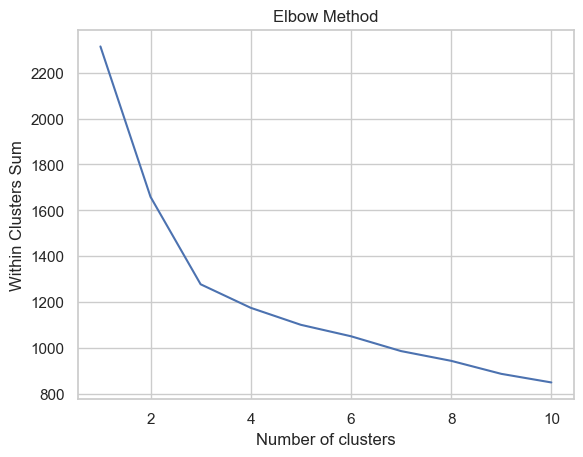

CPU times: total: 453 ms
Wall time: 1.51 s


In [31]:
%%time
elbow_graph(
    normalized_values
)

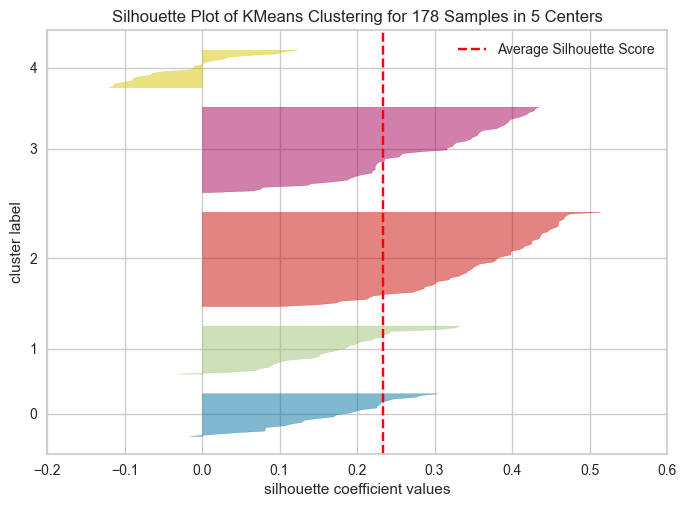

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 178 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [48]:
# Creating the K-Means model with number cluster found
# using Elbow method.

model = KMeans(
    n_clusters   = 5, 
    init         = "k-means++", 
    max_iter     = 300,
    n_init       = 10, 
    random_state = 20
)


# Buiding silhoutte graph for view the cluster's quality. 

silhoutte_view = SilhouetteVisualizer(model, colors="yellowbrick")
silhoutte_view.fit(normalized_values)
silhoutte_view.show()

In [50]:
# Verify the quality of clusters builded with silhoutte score. 

silhoutte = metrics.silhouette_score(
    normalized_values, 
    model.labels_, 
    metric="euclidean"
)

print(f"A silhueta do modelo é de aproximadamente: {silhoutte.round(3)}")

A silhueta do modelo é de aproximadamente: 0.234


In [51]:
# Verify the quality of clusters builded with Davis Bouldin.

davis_bouldin = metrics.davies_bouldin_score(
    normalized_values, 
    model.labels_
) 

print(f"Índice Davis Bouldin do modelo : {davis_bouldin.round(3)}")

Índice Davis Bouldin do modelo : 1.684


#### Com redução de dimensionalidade pelo PCA

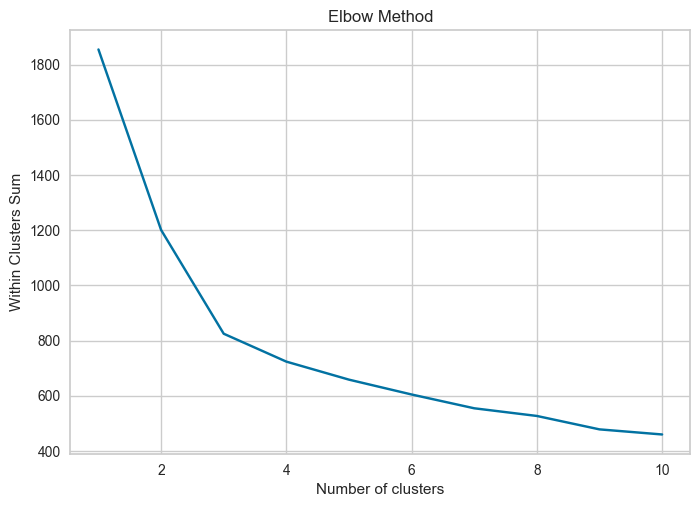

CPU times: total: 375 ms
Wall time: 451 ms


In [52]:
%%time
elbow_graph(
    df_pca.values
)